#### Link to Google Drive and load modules

In [ ]:
# link to Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive
'My Drive'


In [ ]:
# generic modules
import datetime, os
import itertools
import time
import pickle

# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#### Load original dataset and data exploration

Problem: can we predict whether tomorrow will rain in Australia based on today's meteorological data?

source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [ ]:
# load dataset
folder = './gdrive/My Drive/Teaching/CS4305TU Applied Machine Learning/RainfallAustralia/'
filename = 'weatherAUS.csv'
df = pd.read_csv(folder+filename)

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,12/2/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12/3/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,12/4/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,12/5/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
# let's select a single city
print(df.groupby('Location').count()['Date'].sort_values(ascending=False).head(10))

# let's pick Darwin
df = df[df.Location == 'Darwin']
df.head()

Location
Canberra        3418
Sydney          3337
Perth           3193
Darwin          3192
Hobart          3188
Brisbane        3161
Adelaide        3090
Bendigo         3034
Townsville      3033
AliceSprings    3031
Name: Date, dtype: int64


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
135921,7/1/2008,Darwin,20.0,33.1,0.0,4.4,11.0,E,41.0,ENE,SSE,13.0,17.0,81.0,32.0,1016.0,1012.1,1.0,2.0,25.4,32.3,No,No
135922,7/2/2008,Darwin,19.4,32.4,0.0,6.0,10.4,ENE,50.0,SE,E,15.0,28.0,81.0,17.0,1016.8,1012.4,1.0,1.0,24.3,31.9,No,No
135923,7/3/2008,Darwin,18.2,31.8,0.0,8.0,11.0,E,46.0,ESE,ENE,22.0,19.0,38.0,24.0,1017.2,1013.0,0.0,1.0,24.3,31.2,No,No
135924,7/4/2008,Darwin,17.3,30.7,0.0,7.0,10.4,E,44.0,SE,E,22.0,13.0,55.0,16.0,1017.3,1013.6,2.0,6.0,21.3,29.8,No,No
135925,7/5/2008,Darwin,15.5,30.8,0.0,7.0,10.8,ESE,46.0,E,E,20.0,19.0,37.0,16.0,1016.3,1012.6,1.0,1.0,22.2,29.6,No,No


In [ ]:
# let's check if we have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3192 entries, 135921 to 139112
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3192 non-null   object 
 1   Location       3192 non-null   object 
 2   MinTemp        3191 non-null   float64
 3   MaxTemp        3192 non-null   float64
 4   Rainfall       3192 non-null   float64
 5   Evaporation    3138 non-null   float64
 6   Sunshine       3189 non-null   float64
 7   WindGustDir    3147 non-null   object 
 8   WindGustSpeed  3151 non-null   float64
 9   WindDir9am     3164 non-null   object 
 10  WindDir3pm     3189 non-null   object 
 11  WindSpeed9am   3190 non-null   float64
 12  WindSpeed3pm   3190 non-null   float64
 13  Humidity9am    3191 non-null   float64
 14  Humidity3pm    3190 non-null   float64
 15  Pressure9am    3191 non-null   float64
 16  Pressure3pm    3190 non-null   float64
 17  Cloud9am       3191 non-null   float64
 18  C

In [ ]:
# remove all rows with NaN values
df.dropna(axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3062 entries, 135921 to 139112
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3062 non-null   object 
 1   Location       3062 non-null   object 
 2   MinTemp        3062 non-null   float64
 3   MaxTemp        3062 non-null   float64
 4   Rainfall       3062 non-null   float64
 5   Evaporation    3062 non-null   float64
 6   Sunshine       3062 non-null   float64
 7   WindGustDir    3062 non-null   object 
 8   WindGustSpeed  3062 non-null   float64
 9   WindDir9am     3062 non-null   object 
 10  WindDir3pm     3062 non-null   object 
 11  WindSpeed9am   3062 non-null   float64
 12  WindSpeed3pm   3062 non-null   float64
 13  Humidity9am    3062 non-null   float64
 14  Humidity3pm    3062 non-null   float64
 15  Pressure9am    3062 non-null   float64
 16  Pressure3pm    3062 non-null   float64
 17  Cloud9am       3062 non-null   float64
 18  C

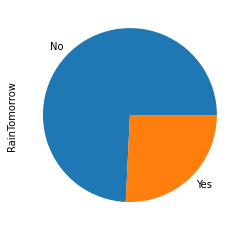

In [ ]:
df['RainTomorrow'].value_counts().plot(kind='pie');

#### Datasets creation 

In [ ]:
# let's select inputs and outpts
Y = df['RainTomorrow']
Y.replace(('Yes', 'No'), (1, 0),inplace=True)


input_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','Sunshine','WindGustSpeed',
                 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
X = df[input_columns]

In [ ]:
# let's create training, validation and test dataset
Xtra,Xval,Ytra,Yval = train_test_split(X,Y,test_size=0.25,shuffle=False)

print(f"Training: X.shape: {Xtra.shape}, Y.shape: {Ytra.shape}")
print(f"Validation: X.shape: {Xval.shape}, Y.shape: {Yval.shape}")

Training: X.shape: (2296, 14), Y.shape: (2296,)
Validation: X.shape: (766, 14), Y.shape: (766,)


In [ ]:
# rescale input dataset (no need for outputs as they are binary labels)
Sx=MinMaxScaler([0,1])
Xtra = Sx.fit_transform(Xtra) # FIT TRANSFORM on training, TRANSFORM on the VALIDATION and TESTING!
Xval = Sx.transform(Xval)

#### Ok, let's explore callbacks!

In [ ]:
# Function for model creation
def FNNmodel(n_features, hidden_neurons=10, dropout_rate=0.1):
  i = Input(shape=(n_features,), name='input_layer')      
  x = Dense(hidden_neurons, activation='sigmoid', name='hidden_layer')(i)
  x = Dropout(dropout_rate)(x)
  x = Dense(1, activation='sigmoid', name='output_layer')(x)  
  model = Model(i,x)
  return model

#### Benchmark model

No callbacks.

In [ ]:
# Benchmark
model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=500,validation_data = (Xval, Yval), verbose=0, batch_size=64)

In [ ]:
# function for plotting training history
def plot_training_history(r, figsize=(10,3)):
  f, axes = plt.subplots(1,2,figsize=figsize)
  # loss
  axes[0].plot(r.history['loss'], label='Training')
  axes[0].plot(r.history['val_loss'], label='Validation')
  axes[0].set_title('Loss trajectories')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  # accuracy
  axes[1].plot(r.history['accuracy'], label='Training')
  axes[1].plot(r.history['val_accuracy'], label='Validation')
  axes[1].set_title('Accuracy trajectories')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')

  # adjust plot
  f.tight_layout()
  return f, axes

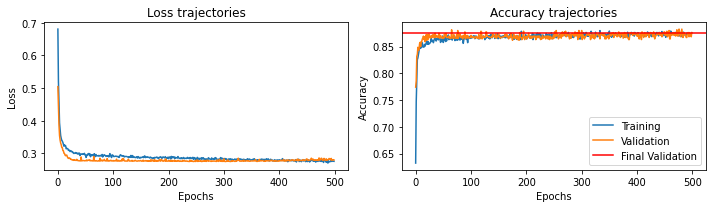

In [ ]:
# plot training history
f, axes = plot_training_history(r, figsize=(10,3))

# compute and plot final accuracy on validation
Yval_pred = model.predict(Xval)>0.5
final_val_acc = accuracy_score(Yval,Yval_pred)
axes[1].axhline(y=final_val_acc, color='red') 
# add legend
axes[1].legend(['Training','Validation','Final Validation'])

#### `EarlyStopping` to improve generalization performances

In [ ]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, 
                              min_delta=1e-4, mode='auto', restore_best_weights=True)

model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=500,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=[earlyStopping])

Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping


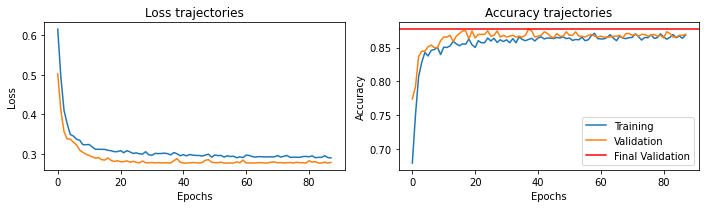

In [ ]:
# plot training history
f, axes = plot_training_history(r, figsize=(10,3))

# compute and plot final accuracy on validation
Yval_pred = model.predict(Xval)>0.5
final_val_acc = accuracy_score(Yval,Yval_pred)
axes[1].axhline(y=final_val_acc, color='red') 
# add legend
axes[1].legend(['Training','Validation','Final Validation']);

#### `TimeStopping` to stop training after a given time



In [ ]:
# Time Stopping
from tensorflow_addons.callbacks import TimeStopping

timeStopping = TimeStopping(seconds=10, verbose=1)

model = FNNmodel(len(input_columns),hidden_neurons=10, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=500,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=[timeStopping])

Timed stopping at epoch 119 after training for 0:00:10


#### Multiple Callbacks: `EarlyStopping` and `TimeStopping` together


In [ ]:
# Callbacks
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, 
                              min_delta=1e-4, mode='auto', restore_best_weights=True)
timeStopping = TimeStopping(seconds=10, verbose=1)
callbacks = [earlyStopping, timeStopping]

model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=500,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=callbacks)

Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping


#### Saving model with `ModelCheckpoint`

In [ ]:
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint('FNN_model_weights.hdf5', save_best_only=True, monitor='val_accuracy', 
                                  mode='auto', save_weights_only=True)

model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=500,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=[modelCheckpoint])

In [ ]:
# check if model was saved
!ls

FNN_model_weights.hdf5	gdrive	sample_data


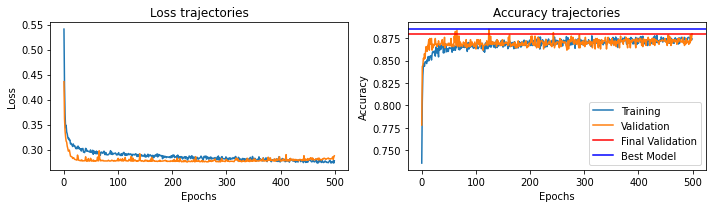

In [ ]:
# plot training history
f, axes = plot_training_history(r, figsize=(10,3))

# compute and plot final accuracy on validation
Yval_pred = model.predict(Xval)>0.5
final_val_acc = accuracy_score(Yval,Yval_pred)
axes[1].axhline(y=final_val_acc, color='red') 

# lodd best model weights and recompute accuracy
model.load_weights('FNN_model_weights.hdf5')
Yval_pred = model.predict(Xval)>0.5
best_val_acc = accuracy_score(Yval,Yval_pred)
axes[1].axhline(y=best_val_acc, color='blue') 

# add legend
axes[1].legend(['Training','Validation','Final Validation','Best Model']);

#### Changing learning rates dynamically as training progresses: `ReduceLROnPlateau` and `LearningRateScheduler`


In [ ]:
# ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrReduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                             verbose=1, min_delta=5e-5, mode='auto', min_lr=0.0001)

model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.5), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=200,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=[lrReduce])


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.25.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.125.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0625.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.03125.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.015625.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0078125.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.00390625.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.001953125.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.0009765625.

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.00048828125.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.000244140625.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 0.0001220703125.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0001.


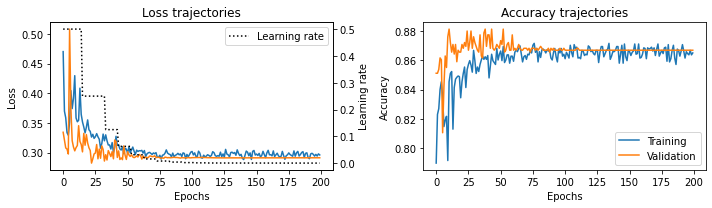

In [ ]:
# plot training history
f, axes = plot_training_history(r, figsize=(10,3))

# add vertical axis and plot learning rate history
twinax = axes[0].twinx()
twinax.plot(r.history['lr'],ls=':',color='black',label='Learning rate')  
twinax.set_ylabel('Learning rate')
axes[1].legend(['Training','Validation']);
twinax.legend()
f.tight_layout()

#### Let's try with `LearningRateScheduler`


In [ ]:
# scheduler
import tensorflow as tf
def scheduler(epoch, lr):
  if epoch%50==0:
    lr = 0.01
  else:
    lr = lr * tf.math.exp(-0.1)
  return lr

# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

lrScheduler = LearningRateScheduler(scheduler)

model = FNNmodel(len(input_columns),hidden_neurons=20, dropout_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.5), metrics=['accuracy'])

r = model.fit(Xtra, Ytra,epochs=200,validation_data = (Xval, Yval), verbose=0, batch_size=64, 
              callbacks=[lrScheduler])

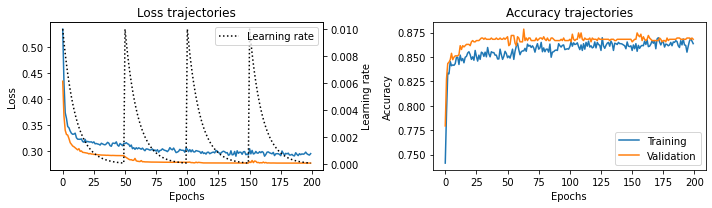

In [ ]:
# plot training history
f, axes = plot_training_history(r, figsize=(10,3))

# add vertical axis and plot learning rate history
twinax = axes[0].twinx()
twinax.plot(r.history['lr'],ls=':',color='black',label='Learning rate')  
twinax.set_ylabel('Learning rate')
axes[1].legend(['Training','Validation']);
twinax.legend()
f.tight_layout()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8086d0d4-4bcd-4dff-b47c-0b35edb81aeb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>